## Module 5
### By: Jennifer Sika

In [49]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
# Unzip file
zip_path = 'data/metadata.csv.zip'  

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('./cord19_data')

print("Extraction completed!\n")

# Check if extraction is successful
print("Extracted files:", os.listdir('./cord19_data'))

# Load data
metadata = pd.read_csv('./cord19_data/metadata.csv', low_memory=False)

# View data
print("\nLoaded Data Shape:", metadata.shape)
metadata.head()

Extraction completed!

Extracted files: ['metadata.csv']

Loaded Data Shape: (1056660, 19)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


### Data Filtering

In [15]:
# Convert publish_time to datetime format
metadata['publish_time'] = pd.to_datetime(metadata['publish_time'], errors='coerce')

# Filter papers: published between May 2020 and May 2022
# Filter papers: abstract has more than 50 words
filtered_metadata = metadata[
    (metadata['publish_time'] >= '2020-05-01') &
    (metadata['publish_time'] <= '2022-05-31') &
    (metadata['abstract'].astype(str).str.split().str.len() > 50)
]

# View the result
print("Filtered Dataset Shape:", filtered_metadata.shape)
filtered_metadata.head()

Filtered Dataset Shape: (351343, 19)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
9612,ejaditj5,NaN,PMC,An adaptive parareal algorithm(),10.1016/j.cam.2020.112915,PMC7155213,32292231,no-cc,"In this paper, we consider the problem of acce...",2020-10-15,"Maday, Y.; Mula, O.",J Comput Appl Math,NaN,NaN,NaN,NaN,document_parses/pmc_json/PMC7155213.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN
9651,3nsllrcj,cb787bfd60086917fe259007679482d24cbce175; 5d0f...,PMC,Nanoplasmid Vectors Co-expressing Innate Immun...,10.1016/j.omtm.2020.04.009,PMC7158766,32296729,no-cc,DNA vaccines expressing codon-optimized Venezu...,2020-06-12,"Suschak, John J.; Dupuy, Lesley C.; Shoemaker,...",Mol Ther Methods Clin Dev,NaN,NaN,NaN,document_parses/pdf_json/cb787bfd60086917fe259...,document_parses/pmc_json/PMC7158766.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN
10713,lfbjvche,84d22b71f6df277a11824433ccf14137303f55f5,PMC,Validation of RESP and PRESERVE score for ARDS...,10.1186/s12871-020-01010-0,PMC7195797,32359363,cc-by,BACKGROUND: RESP score and PRESERVE score have...,2020-05-02,"Petran, Jan; Muelly, Thorsten; Dembinski, Rolf...",BMC Anesthesiol,NaN,NaN,NaN,document_parses/pdf_json/84d22b71f6df277a11824...,document_parses/pmc_json/PMC7195797.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN
10725,3atdlr5k,91ad6ada0e8d209792cfd352c49da89a99713d0d,PMC,St. Corona – eine Fürsprecherin gegen Seuchen?...,10.1007/s00120-020-01209-6,PMC7196716,32367176,cc-by,The knowledge of hagiography and hagiotherapy ...,2020-05-04,"Moll, Friedrich H.; Schwarzburger, Marie-Isabelle",Urologe A,NaN,NaN,NaN,document_parses/pdf_json/91ad6ada0e8d209792cfd...,document_parses/pmc_json/PMC7196716.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN
10730,nbt7ocyy,b382ff1b00757c3cb6a7408d8e993aa6d94d3e28,PMC,Vaping induced pneumonitis: a small community ...,10.1186/s12890-020-1158-2,PMC7197363,32366239,cc-by,BACKGROUND: Electronic cigarettes/e-cigarettes...,2020-05-04,"Silverman, Andrew L.; Siddique, Haseeb; Kumar,...",BMC Pulm Med,NaN,NaN,NaN,document_parses/pdf_json/b382ff1b00757c3cb6a74...,document_parses/pmc_json/PMC7197363.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN


In [21]:
# This is an added step, which is a deviation, but necessary for performance

# Set sample size
sample_size = 25000

# Randomly sample 25,000 papers
sampled_metadata = filtered_metadata.sample(n=sample_size, random_state=42)

# Save sampled dataset for reproducibility
sampled_metadata.to_csv('sampled_metadata.csv', index=False)

# View sampled dataset
print("Sampled Dataset Shape:", sampled_metadata.shape)
sampled_metadata.head()

Sampled Dataset Shape: (25000, 19)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
1004461,icx1ekgy,db2077b2e7281325351f4da95edf6985ab350675,Medline; PMC,Assessing private provider perceptions and the...,10.1371/journal.pone.0250644,PMC8104441,33961645,cc-by,BACKGROUND: The World Health Organization rece...,2021-05-07,"Nguyen, Lan Huu; Tran, Phuong Thi Minh; Dam, T...",PLoS One,NaN,NaN,NaN,document_parses/pdf_json/db2077b2e7281325351f4...,document_parses/pmc_json/PMC8104441.xml.json,https://doi.org/10.1371/journal.pone.0250644; ...,233997611.0
867482,x3okaio7,d1a493874021e51c734f72c5e734ae498e968555,Elsevier; Medline; PMC; WHO,Immune responses to SARS-CoV-2 vaccination in ...,10.1016/j.jtct.2022.04.017,PMC9040419,35472554,no-cc,Background: SARS-CoV-2 vaccines are capable of...,2022-04-26,"Jarisch, Andrea; Wiercinska, Eliza; Huenecke, ...",Transplant Cell Ther,NaN,NaN,NaN,document_parses/pdf_json/d1a493874021e51c734f7...,document_parses/pmc_json/PMC9040419.xml.json,https://doi.org/10.1016/j.jtct.2022.04.017; ht...,248396417.0
18723,2uj8fvgd,5148f352bbe0940d9ce2c9d85ce4f7fa1c6963b4; e335...,PMC,Effect of alcohol label designs with different...,10.1111/add.15327,PMC8248341,33169443,cc-by-nc,BACKGROUND AND AIMS: The UK low‐risk drinking ...,2021-01-19,"Gold, Natalie; Egan, Mark; Londakova, Kristina...",Addiction,NaN,NaN,NaN,document_parses/pdf_json/5148f352bbe0940d9ce2c...,document_parses/pmc_json/PMC8248341.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8...,NaN
170442,fpg3ryse,NaN,Medline,Overcoming reward deficiency syndrome by the i...,10.1515/jom-2021-0026,NaN,35411759,unk,Many individuals in the United States are plag...,2022-04-12,"Blum, Kenneth; Soni, Diwanshu; Badgaiyan, Raje...",Journal of osteopathic medicine,NaN,NaN,NaN,NaN,NaN,https://doi.org/10.1515/jom-2021-0026; https:/...,248086992.0
955690,1rdlwwd5,4c05211a63e5c5c6838fa320d7434ef33ed2d0b8,Medline; PMC,Vaccine Hesitancy Counseling—an Educational In...,10.1007/s40670-021-01495-5,PMC8776394,35079448,no-cc,INTRODUCTION: There has been a recent rise in ...,2022-01-21,"Kelekar, Arati; Rubino, Ida; Kavanagh, Maurice...",Med Sci Educ,NaN,NaN,NaN,document_parses/pdf_json/4c05211a63e5c5c6838fa...,document_parses/pmc_json/PMC8776394.xml.json,https://doi.org/10.1007/s40670-021-01495-5; ht...,246166189.0


#### Summary
We filtered the CORD-19 dataset to retain only articles published between May 2020 and May 2022. To ensure meaningful content for topic modeling, we excluded articles with abstracts containing fewer than 50 words. Due to computational constraints, we selected a representative random sample of 25,000 articles from the filtered dataset for this study.

### Data Preprocessing

In [25]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/jennifer/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jennifer/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jennifer/nltk_data...


True

In [27]:
# Initialize preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define preprocessing function
def preprocess(text):
    if pd.isnull(text):
        return ""
    # Lowercase
    text = text.lower()
    # Remove numbers and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

# Apply preprocessing to the abstracts
sampled_metadata['cleaned_abstract'] = sampled_metadata['abstract'].apply(preprocess)

# View cleaned data
sampled_metadata[['title', 'cleaned_abstract']].head()

,title,cleaned_abstract
1004461,Assessing private provider perceptions and the...,background world health organization recently ...
867482,Immune responses to SARS-CoV-2 vaccination in ...,background sarscov vaccine capable inducing co...
18723,Effect of alcohol label designs with different...,background aim lowrisk drinking guideline lrdg...
170442,Overcoming reward deficiency syndrome by the i...,many individual united state plagued addiction...
955690,Vaccine Hesitancy Counseling—an Educational In...,introduction recent rise public perception vac...


#### Summary
The sampled dataset underwent a series of preprocessing steps to standardize the textual data for topic modeling. Abstracts were cleaned by lowercasing, removing punctuation and numbers, eliminating stopwords, and applying lemmatization. This process was made especially easy by the flowchart provided in the paper. 

### Feature Extraction

In [31]:
# Function to find common n-grams
def get_top_ngrams(texts, n=2, top_k=50):
    ngram_counter = Counter()
    for text in texts:
        tokens = text.split()
        n_grams = ngrams(tokens, n)
        ngram_counter.update(n_grams)
    return ngram_counter.most_common(top_k)

# Find top bigrams (n=2)
top_bigrams = get_top_ngrams(sampled_metadata['cleaned_abstract'], n=2, top_k=30)

# Display top 30 bigrams
for bigram, count in top_bigrams:
    print(f"{' '.join(bigram)}: {count}")

covid pandemic: 7175
coronavirus disease: 3541
disease covid: 3187
covid patient: 3118
mental health: 2591
acute respiratory: 2440
public health: 2348
sarscov infection: 2326
severe acute: 1977
respiratory syndrome: 1972
health care: 1740
syndrome coronavirus: 1717
risk factor: 1687
patient covid: 1684
coronavirus sarscov: 1582
covid infection: 1550
age year: 1215
immune response: 1089
clinical trial: 1072
intensive care: 1056
study aimed: 1018
covid vaccine: 1009
supplementary material: 998
covid case: 988
severe covid: 973
result total: 900
online version: 897
material available: 894
contains supplementary: 884
infectious disease: 879


In [33]:
# Define selected n-grams based on frequency analysis
selected_ngrams = {
    "covid pandemic": "covid_pandemic",
    "coronavirus disease": "coronavirus_disease",
    "mental health": "mental_health",
    "acute respiratory": "acute_respiratory",
    "public health": "public_health",
    "sarscov infection": "sarscov_infection",
    "severe acute": "severe_acute",
    "respiratory syndrome": "respiratory_syndrome",
    "health care": "health_care",
    "risk factor": "risk_factor",
    "immune response": "immune_response",
    "clinical trial": "clinical_trial",
    "intensive care": "intensive_care",
    "covid vaccine": "covid_vaccine",
    "infectious disease": "infectious_disease"
}

# Function to merge n-grams into single tokens
def merge_ngrams(text, ngram_dict):
    for phrase, merged in ngram_dict.items():
        text = text.replace(phrase, merged)
    return text

# Apply n-gram merging to abstracts
sampled_metadata['cleaned_abstract'] = sampled_metadata['cleaned_abstract'].apply(lambda x: merge_ngrams(x, selected_ngrams))

# Preview result
sampled_metadata[['title', 'cleaned_abstract']].head()

,title,cleaned_abstract
1004461,Assessing private provider perceptions and the...,background world health organization recently ...
867482,Immune responses to SARS-CoV-2 vaccination in ...,background sarscov vaccine capable inducing co...
18723,Effect of alcohol label designs with different...,background aim lowrisk drinking guideline lrdg...
170442,Overcoming reward deficiency syndrome by the i...,many individual united state plagued addiction...
955690,Vaccine Hesitancy Counseling—an Educational In...,introduction recent rise public perception vac...


In [37]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    max_df=0.7,     # Remove terms that appear in more than 70% of documents
    min_df=10,      # Remove rare terms (appears in less than 10 documents)
    max_features=50000,  # Limit vocabulary size due to processing constraints
    stop_words='english' # Use built-in English stopword list
)

# Fit and transform the cleaned abstracts
tfidf_matrix = vectorizer.fit_transform(sampled_metadata['cleaned_abstract'])

# Display TF-IDF matrix shape
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

TF-IDF Matrix Shape: (25000, 12762)


#### Summary
Meaningful multi-word expressions were merged into single tokens using a manually selected set of frequent n-grams. The resulting text was then converted into a TF-IDF representation for feature extraction. This process was less clearly specified in the paper, as it only mentioned that n-grams were manually selected without providing an explicit list. While the paper described merging n-grams up to six words, I chose to focus only on bigrams. Additionally, the paper used a minimum document frequency threshold of 1,000, whereas I used a threshold of 10 to adapt to the reduced dataset size.

### Topic Modeling

In [51]:
# Set number of topics 
k = 20  # The paper used 20 after stability analysis

# Initialize NMF model
nmf_model = NMF(n_components=k, random_state=42, init='nndsvda', max_iter=500)

# Fit the model to the TF-IDF matrix
W = nmf_model.fit_transform(tfidf_matrix)  
H = nmf_model.components_                  

print("NMF completed.")
print("W shape (Documents x Topics):", W.shape)
print("H shape (Topics x Terms):", H.shape)

NMF completed.
W shape (Documents x Topics): (25000, 20)
H shape (Topics x Terms): (20, 12762)


In [53]:
# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Function to display top words for each topic
def display_topics(H, feature_names, top_n=15):
    for topic_idx, topic in enumerate(H):
        print(f"Topic {topic_idx+1}:")
        top_indices = topic.argsort()[::-1][:top_n]
        top_terms = [feature_names[i] for i in top_indices]
        print(", ".join(top_terms))
        print()

# Display topics
display_topics(H, feature_names, top_n=15)

Topic 1:
care, service, healthcare, nurse, telemedicine, practice, telehealth, visit, medical, staff, hospital, provider, health_care, home, covid_pandemic

Topic 2:
patient, treatment, clinical, day, hospital, therapy, symptom, surgery, treated, complication, median, acute, outcome, admitted, severe

Topic 3:
cell, expression, immune, gene, lung, mouse, cytokine, response, protein, pathway, tissue, disease, receptor, role, inflammation

Topic 4:
sarscov, virus, viral, infection, coronavirus, rna, human, severe_acute_respiratory_syndrome, respiratory, transmission, host, sarscov_infection, antiviral, influenza, infected

Topic 5:
anxiety, depression, mental_health, stress, psychological, symptom, sleep, participant, disorder, scale, study, distress, score, survey, questionnaire

Topic 6:
test, sample, testing, detection, assay, positive, sensitivity, rtpcr, diagnostic, swab, sarscov, specificity, negative, pcr, rapid

Topic 7:
vaccine, vaccination, covid_vaccine, dose, vaccinated, mrna

In [55]:
# Confirm publish_time is available in sampled data
sampled_metadata['publish_time'] = pd.to_datetime(sampled_metadata['publish_time'], errors='coerce')

# Add topic distribution
sampled_metadata['dominant_topic'] = np.argmax(W, axis=1)

# Group by month and topic
sampled_metadata['month'] = sampled_metadata['publish_time'].dt.to_period('M')

# Count documents per topic over time
topic_trends = sampled_metadata.groupby(['month', 'dominant_topic']).size().unstack(fill_value=0)

# Display topic trends table
topic_trends.head()

dominant_topic,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
month,,,,,,,,,,,,,,,,,,,,
2020-05,14,124,35,41,12,36,13,86,9,37,21,20,85,14,12,16,93,46,92,20
2020-06,28,116,36,39,17,34,11,85,18,37,29,23,84,12,20,18,97,51,85,18
2020-07,17,150,61,28,21,44,12,66,21,48,27,23,77,20,22,17,115,47,71,30
2020-08,23,131,62,49,21,46,7,73,25,38,12,21,69,16,22,27,125,58,68,27
2020-09,20,134,76,31,27,37,19,66,20,66,31,28,74,23,28,16,142,54,66,41


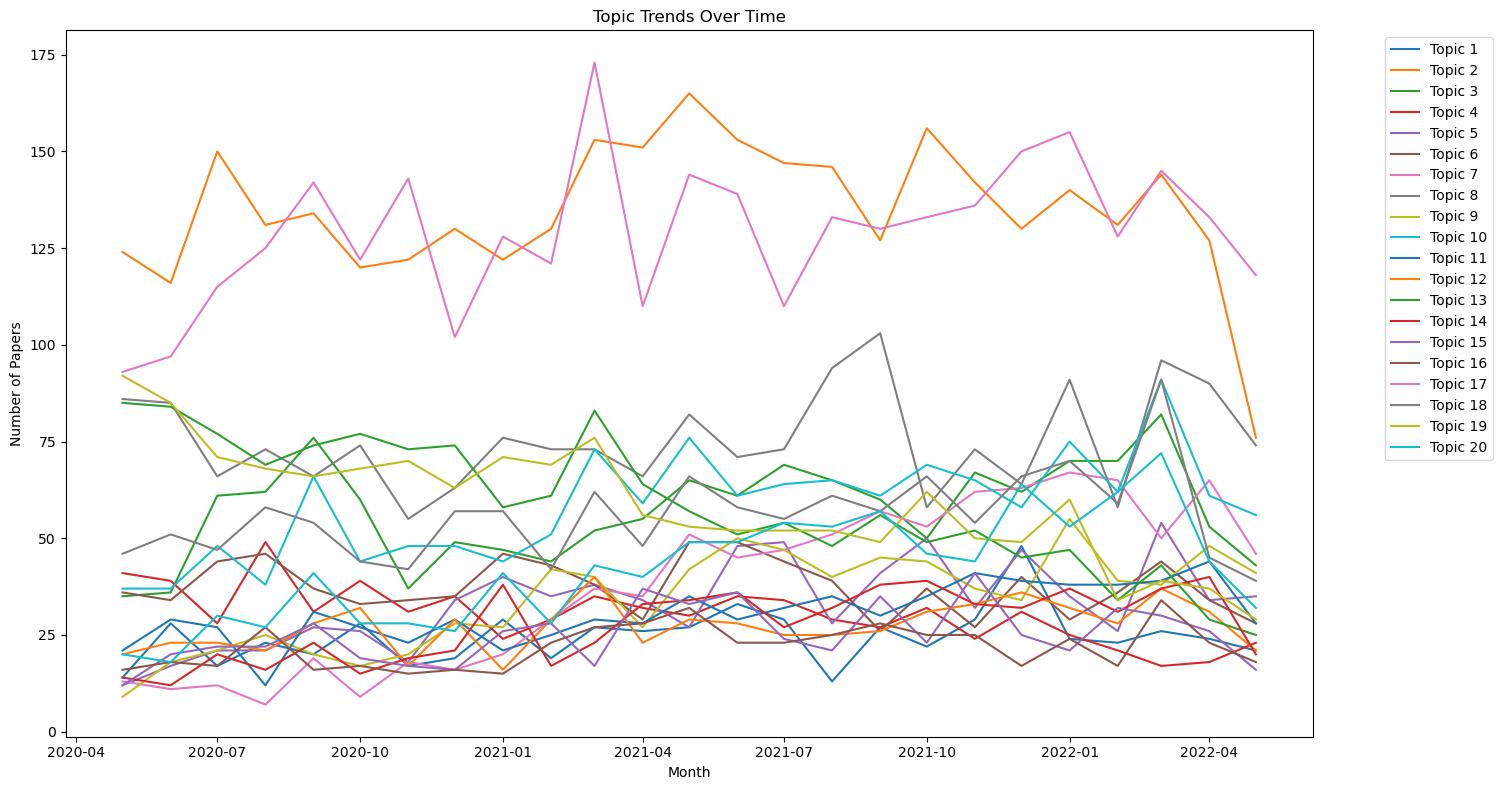

In [57]:
# Plot topic trends
plt.figure(figsize=(15, 8))

# Plot each topic's trend
for topic_num in topic_trends.columns:
    plt.plot(topic_trends.index.to_timestamp(), topic_trends[topic_num], label=f"Topic {topic_num+1}")

plt.xlabel('Month')
plt.ylabel('Number of Papers')
plt.title('Topic Trends Over Time')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

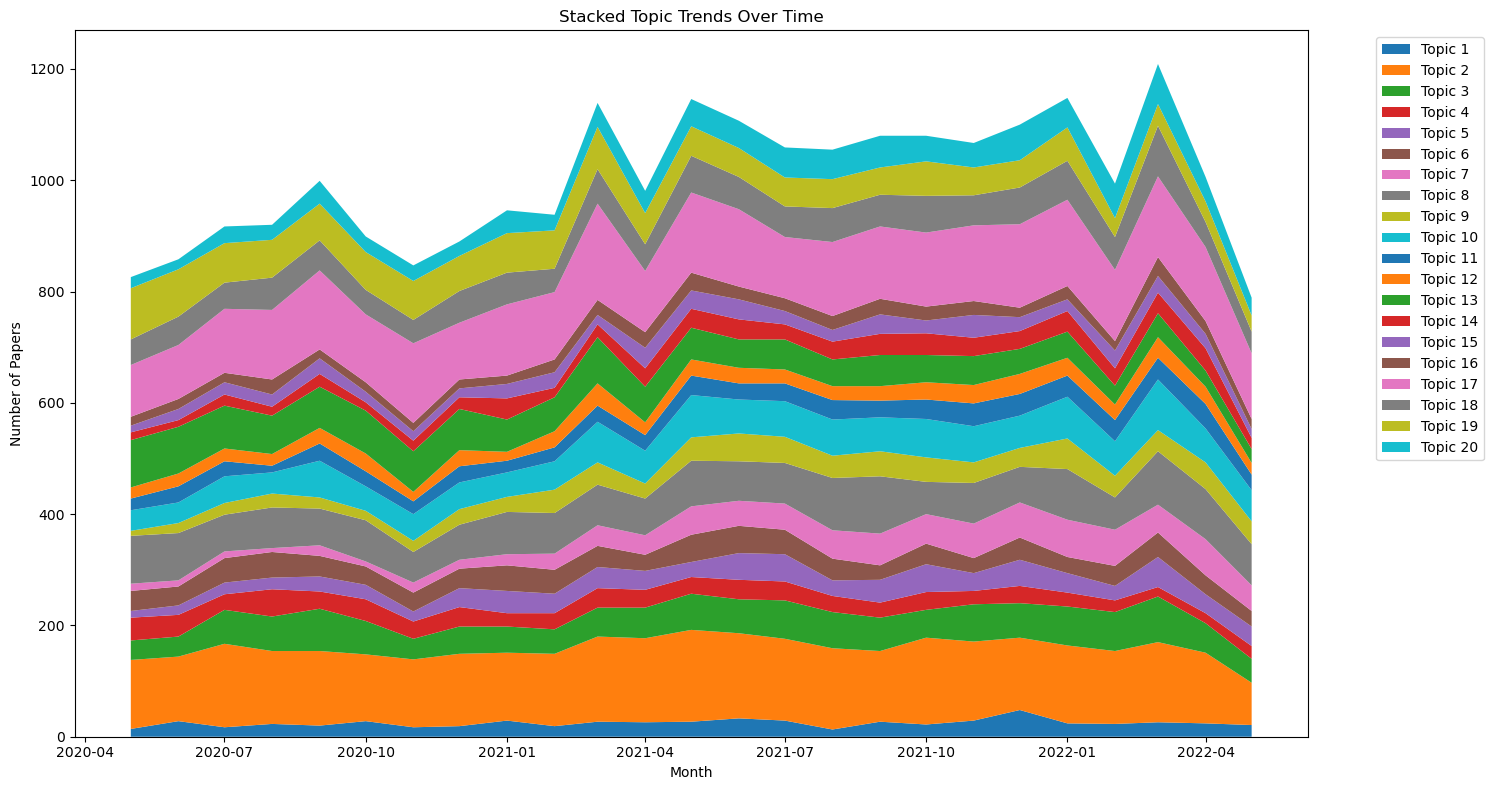

In [59]:
# Prepare data
topic_trends.index = topic_trends.index.to_timestamp()

# Plot stacked area
plt.figure(figsize=(15,8))
plt.stackplot(topic_trends.index, topic_trends.T, labels=[f"Topic {i+1}" for i in topic_trends.columns])

plt.xlabel('Month')
plt.ylabel('Number of Papers')
plt.title('Stacked Topic Trends Over Time')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), ncol=1)
plt.tight_layout()
plt.show()

#### Summary
I applied NMF to the TF-IDF matrix to extract 20 topics, following the paper's choice without redoing stability analysis, since my focus was on reproducing the results. Each document was assigned a dominant topic, and I visualized how topics changed over time using both line plots and stacked area plots. The trends showed similar patterns to those reported in the paper, though some differences were expected due to working with a smaller sample.